# SciKit Pipeline and Transform Demo

This expands the SciKit Learn logistic regression demo to incorporate pipelines and regularization.

This uses the grad student admissions data again.

## Setup

Let's import some packages:

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.special import logit
import matplotlib.pyplot as plt
import statsmodels.api as sm

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [5]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score

In [6]:
rng = np.random.RandomState(20201031)

## Read Data

Load the UCLA grad admissions data.

In [7]:
students = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
students.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Let's train and test:

In [8]:
test_students = students.sample(frac=0.2, random_state=rng)

In [9]:
train_mask = pd.Series(True, index=students.index)
train_mask[test_students.index] = False
train_students = students[train_mask].copy()
train_students.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


And now we set up the predictor and outcome variables:

In [10]:
feat_cols = ['gre', 'gpa', 'rank']
out_col = 'admit'
train_x = train_students[feat_cols]
train_y = train_students[out_col]

## Transformations

We're going to start by standardizing all the features, so that regularization works better.

SciKit-Learn provides *transformers* that can do this for us. Transformers have a `fit` method, like other models, to learn the transformation parameters; they also have a `transform` that modifies data.

Let's fit a standard scalar:

In [11]:
scale = StandardScaler()
scale.fit(train_x)

StandardScaler()

The scalar learned the mean of each feature:

In [12]:
scale.mean_

array([584.6875    ,   3.38034375,   2.559375  ])

And the standard deviation (square root of variance):

In [13]:
scale.scale_

array([113.31053501,   0.38513091,   0.95667372])

And it can transform data:

In [14]:
scale.transform(train_x)[:5, :]

array([[-1.80642956,  0.59630698,  0.46058023],
       [ 0.66465576,  0.75209816,  0.46058023],
       [ 1.90019842,  1.60894966, -1.62999669],
       [ 0.48814967, -0.4942313 ,  1.50586869],
       [-0.5708869 , -1.16932642,  1.50586869]])

SciKit-Learn doesn't know about Pandas, so it returns a NumPy matrix.  The indexing gives us the first 5 rows.

**Verify that these are the z-standardized values of the first 5 rows of the training data.**

If we apply the transform to the test data, it uses the transforms learned from the training data to do the job:

In [15]:
scale.transform(test_students[feat_cols])[:5,:]

array([[ 1.01766795,  0.88192414, -0.58470823],
       [ 0.84116186,  0.75209816, -0.58470823],
       [ 0.13513748,  0.51841139, -1.62999669],
       [-0.92389909,  0.18086383, -0.58470823],
       [-0.04136862, -0.23457933,  1.50586869]])

## Set Up the Pipeline

Now we're going to use a standard scaler in a pipeline with a logistic regression:

In [16]:
pure_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('classify', LogisticRegression(penalty='none'))
])

Now we can fit the pipeline:

In [17]:
pure_pipe.fit(train_x, train_y)

Pipeline(steps=[('standardize', StandardScaler()),
                ('classify', LogisticRegression(penalty='none'))])

The `named_steps` exposes the individual steps by name, so we can look up our coefficients:

In [18]:
pure_pipe.named_steps['classify'].coef_

array([[ 0.24559163,  0.3354789 , -0.52467376]])

What's the training accuracy of this model?

In [19]:
accuracy_score(train_y, pure_pipe.predict(train_x))

0.709375

## Regularized Model

Let's do a regularized model now!  We're going to use $L_2$ (Ridge) regression, which is the default for logistic regression.

We will use `LogisticRegressionCV` to select regression strength using cross-validation on the training data.  It will automatically try 10 different regression strengths.

In [20]:
reg_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('classify', LogisticRegressionCV())
])

Now train it:

In [21]:
reg_pipe.fit(train_x, train_y)

Pipeline(steps=[('standardize', StandardScaler()),
                ('classify', LogisticRegressionCV())])

Now let's grab the logistic regression out of it and start looking at some of its parameters:

In [22]:
reg_model = reg_pipe.named_steps['classify']
reg_model.coef_

array([[ 0.24039303,  0.32109707, -0.50014372]])

You can see that these coefficients are a little smaller than they were in the un-regularized model. Regularization is doing some work!

What regularization strength did it learn?

In [23]:
reg_model.C_

array([0.35938137])

Remember $C = 1/\lambda$, to connect this value to the videos.

What's our training accuracy?

In [24]:
accuracy_score(train_y, reg_pipe.predict(train_x))

0.709375

A quick note: the logistic model is trained on *transformed* variables. If we try to apply it to un-transformed varaibles, it will have no idea what to do:

In [25]:
accuracy_score(train_y, reg_model.predict(train_x))

0.321875

The pipeline makes sure that the same transforms are applied at predict time that were learned at model training time.

## Decision Tree


In [42]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [83]:
dtree = DecisionTreeClassifier(max_depth=2)
dtree.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=2)

[Text(167.4, 181.2, 'gpa <= 3.435\nsamples = 320\nvalue = [217, 103]\nclass = Deny'),
 Text(83.7, 108.72, 'rank <= 2.5\n177\n[138, 39]\nDeny'),
 Text(41.85, 36.23999999999998, '89\n[63, 26]\nDeny'),
 Text(125.55000000000001, 36.23999999999998, '88\n[75, 13]\nDeny'),
 Text(251.10000000000002, 108.72, 'rank <= 1.5\n143\n[79, 64]\nDeny'),
 Text(209.25, 36.23999999999998, '23\n[5, 18]\nAdmit'),
 Text(292.95, 36.23999999999998, '120\n[74, 46]\nDeny')]

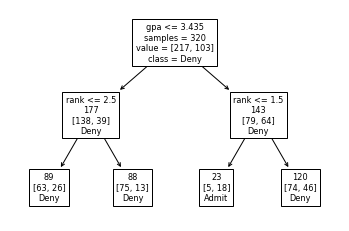

In [84]:
plot_tree(dtree, feature_names=feat_cols, impurity=False, class_names=['Deny', 'Admit'], label='root')

In [85]:
accuracy_score(train_y, dtree.predict(train_x))

0.71875

Now let's make an unlimited decision tree:

In [86]:
uldtree = DecisionTreeClassifier()
uldtree.fit(train_x, train_y)

DecisionTreeClassifier()

In [88]:
accuracy_score(train_y, uldtree.predict(train_x))

0.99375

## Test Data Accuracy

Let's test our two different models on the testing data.

In [65]:
test_x = test_students[feat_cols]
test_y = test_students[out_col]

In [66]:
pure_y = pure_pipe.predict(test_x)

In [67]:
reg_y = reg_pipe.predict(test_x)

What is our pure-model accuracy?

In [89]:
accuracy_score(test_y, pure_y)

0.6875

And our reg-model accuracy?

In [90]:
accuracy_score(test_y, reg_y)

0.7

The two regression models had the same training accuracy, but the regularized model does slightly better on the test data.

We would like to get an estimate of whether this meaningful or not.  We can't use a proportion test, because the proportions are paired. We can't use a *t*-test, because we don't have multiple samples of continuous values.

One of the most common answers is to use McNemar's test for the null hypothesis that the two classifiers have the same accuracy.  To compute that, we need a **contingency table** — it's like a confusion matrix, but it's for documenting when two classifiers get the result right or wrong.

We'll start by making a data frame with whether or not each classifier got the result correct (indexed with the test index, just to keep things linkable):

In [28]:
test_correct = pd.DataFrame({
    'Pure': pure_y == test_y,
    'Reg': reg_y == test_y
}, index=test_y.index)
test_correct.head()

,Pure,Reg
117,False,True
272,False,False
139,True,True
109,True,True
230,True,True


Now we can compute the *contingency table* by **cross-tabulating** the two columns:

In [29]:
ct = pd.crosstab(test_correct['Pure'], test_correct['Reg'])
ct

Reg,False,True
Pure,,
False,24,1
True,0,55


There's only one data point that differed, not a lot of difference here.

We can now compute the McNemar result:

In [30]:
print(sm.stats.mcnemar(ct))

pvalue      1.0
statistic   0.0


Ok, that is not significant.

Let's look at Wilson confidence intervals.  First the pure model:

In [102]:
sm.stats.proportion_confint(np.sum(pure_y == test_y), len(test_students), method='wilson')

(0.5793222425531255, 0.7784959588710518)

And the regularized model:

In [101]:
sm.stats.proportion_confint(np.sum(reg_y == test_y), len(test_students), method='wilson')

(0.5923184607866026, 0.7893542873991866)

We could also bootstrap our test data to estimate confidence intervals:

In [31]:
def boot_sample(test_x, test_y):
    n = len(test_x)
    # get positions
    sample = rng.randint(n, size=n)

    # get data
    bs_x = test_x.iloc[sample, :]
    bs_y = test_y.iloc[sample]
    return bs_x, bs_y

def boot_class_metric(test_x, test_y, model, metric=accuracy_score, nboot=10000):
    test_d = model.predict(test_x)
    val = metric(test_y, test_d)
    
    boot_vals = np.empty(nboot)
    for i in range(nboot):
        bs_x, bs_y = boot_sample(test_x, test_y)
        bs_d = model.predict(bs_x)
        boot_vals[i] = metric(bs_y, bs_d)
    
    return val, np.quantile(boot_vals, [0.025, 0.975])

And bootstrap accuracy on our test data:

In [32]:
boot_class_metric(test_x, test_y, pure_pipe)

(0.6875, array([0.5875, 0.7875]))

And with the other model:

In [33]:
boot_class_metric(test_x, test_y, reg_pipe)

(0.7, array([0.6, 0.8]))

We can't claim any any conclusive evidence of improvement.

These metrics are for the accuracy of **these specific models**.  They are not testing the general accuracy of training **this model structure** over data **like this**.  To test that, we could use a careful cross-validation design; just computing 10-fold CV and doing a *t*-test is unlikely to be correct however, but *repeated cross validation* can be effective. See the statistical testing reading.

## Decision Tree Stats

Let's look at the accuracy of our trees.

Compute preds:

In [94]:
dt_y = dtree.predict(test_x)
uldt_y = uldtree.predict(test_x)

Short decision tree:

In [95]:
accuracy_score(test_y, dt_y)

0.7375

And the unlimited tree?

In [96]:
accuracy_score(test_y, uldt_y)

0.525

**Exercise:** is this significant?

Observe the overfitting of the unlimited decision tree!